In [28]:
!pip install missingno


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: C:\Users\kiera\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
import missingno

In [30]:
# Load a sheet into a DataFrame by its name
df = pd.read_excel('./files/titanic3.xlsx')
# See basic info about our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [31]:
# Let's do some data exploration by looking at the first and last few rows of our dataframe
df.head(6)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"


In [32]:
df.tail(6)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1303,3,0,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C,NaN,NaN,NaN
1304,3,0,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN
1308,3,0,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,NaN,S,NaN,NaN,NaN


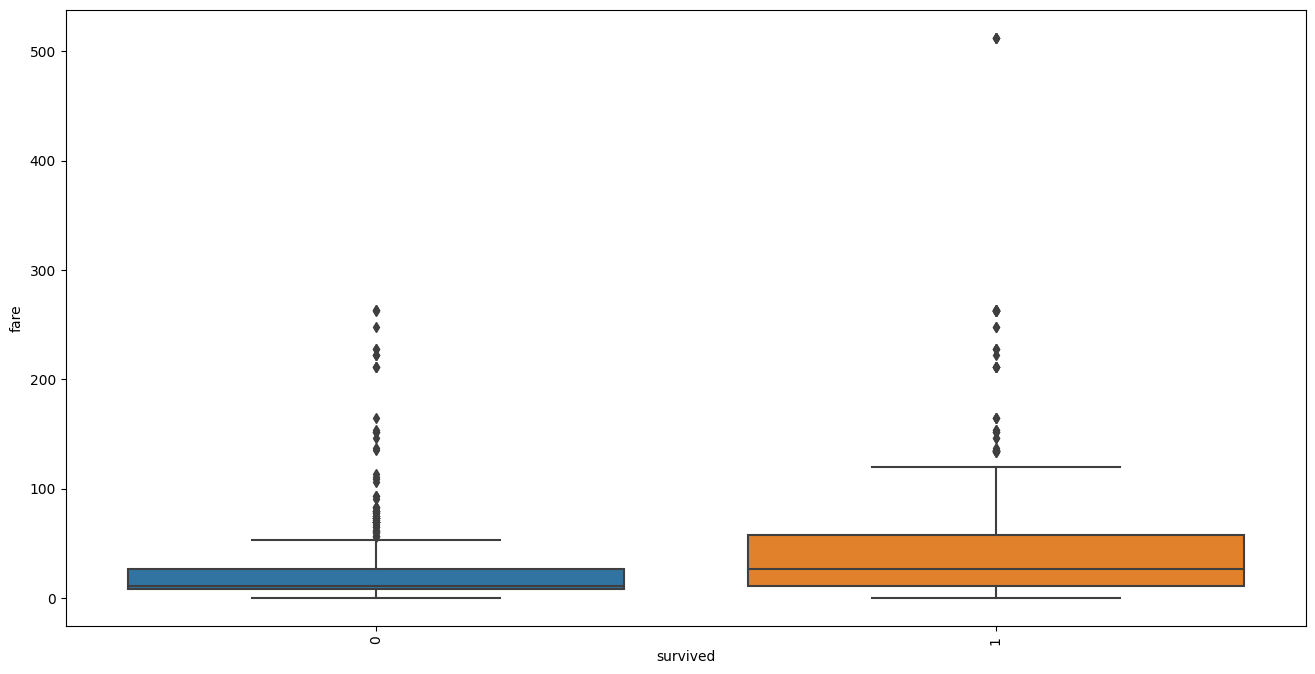

In [33]:
#Let's check our data for outliers in the regarding the people who survived and how much they paid
data = pd.concat([df['survived'], df['fare']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=df['survived'], y=df['fare'], data=data)
plt.xticks(rotation=90);

It is clear that there are outliers that need to be fixed.

In [34]:
# Let's see who are the people that have paid more than 500
df[df['fare'] > 500]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
49,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,3,NaN,"Austria-Hungary / Germantown, Philadelphia, PA"
50,1,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C,3,NaN,"Germantown, Philadelphia, PA"
183,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,3,NaN,NaN
302,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,3,NaN,NaN


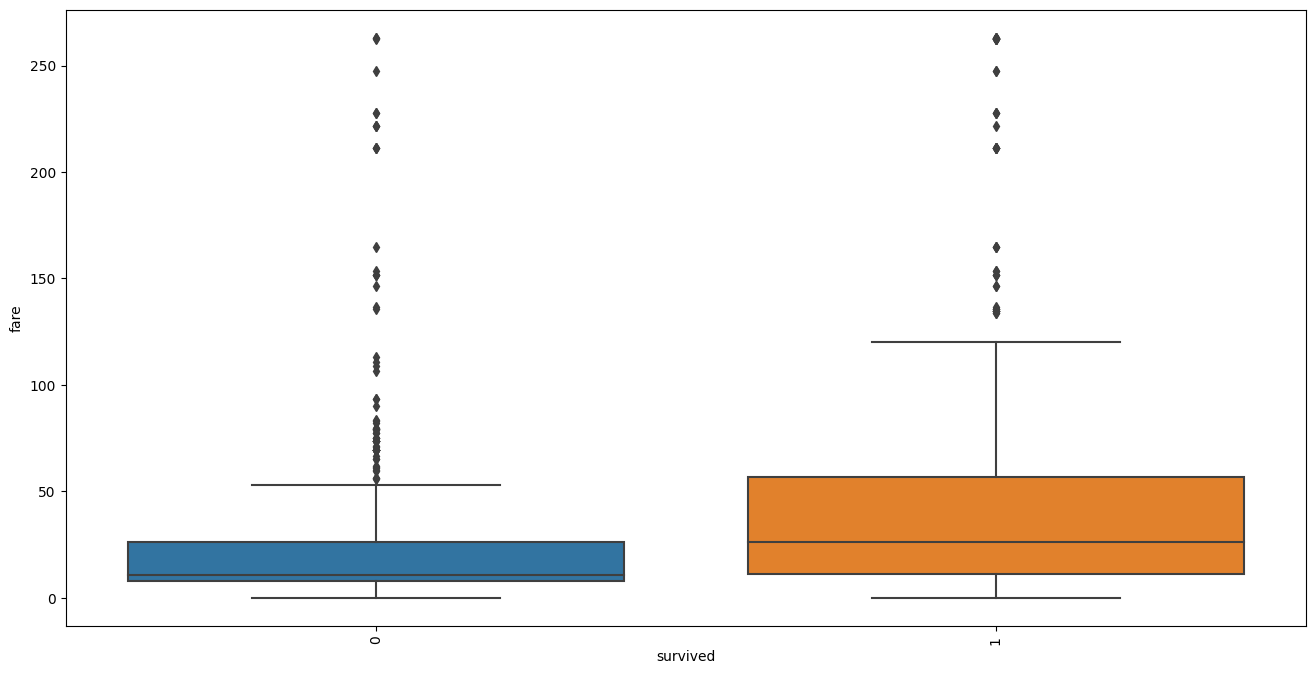

In [35]:
# We are going to change these outliers to the mean price that has been paid by the other passengers, we could do this by simply changing
# the fare price of these passengers but let's use the technique that would be used when there are more than a few outliers
# We use the outlier detection and removal technique

# Calculate the IQR (InterQuartile Range) for the fare column
Q1 = df['fare'].quantile(0.25)
Q3 = df['fare'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bound for outliers, (sidenote, normally the multiplier used to calculate the lower and upper bound is around 1.5
# but this would cause the identification of normal data as outliers resulting in a lot of good data to be lost because it is flagged as an
# outlier. This is why we use such a high multiplier value.
lower_bound = Q1 - 10 * IQR
upper_bound = Q3 + 10 * IQR

# Filter the data to exclude outliers
df = df[(df['fare'] >= lower_bound) & (df['fare'] <= upper_bound)]

# We again check for outliers using the same boxplot as used before
data = pd.concat([df['survived'], df['fare']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=df['survived'], y=df['fare'], data=data)
#fig.axis(ymin=0, ymax=300);
plt.xticks(rotation=90);

We can now see that we have gotten rid of the outliers and the highest fare that was paid is now around 270.

In [36]:
# The following thing we can do is to check how many empty rows each feature/column has.
df.isna().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            0
cabin        1012
embarked        2
boat          822
body         1184
home.dest     561
dtype: int64

In [37]:
# This can form a problem if a certain column has way less data compared to the rest, let's check this
df.count()

pclass       1304
survived     1304
name         1304
sex          1304
age          1041
sibsp        1304
parch        1304
ticket       1304
fare         1304
cabin         292
embarked     1302
boat          482
body          120
home.dest     743
dtype: int64

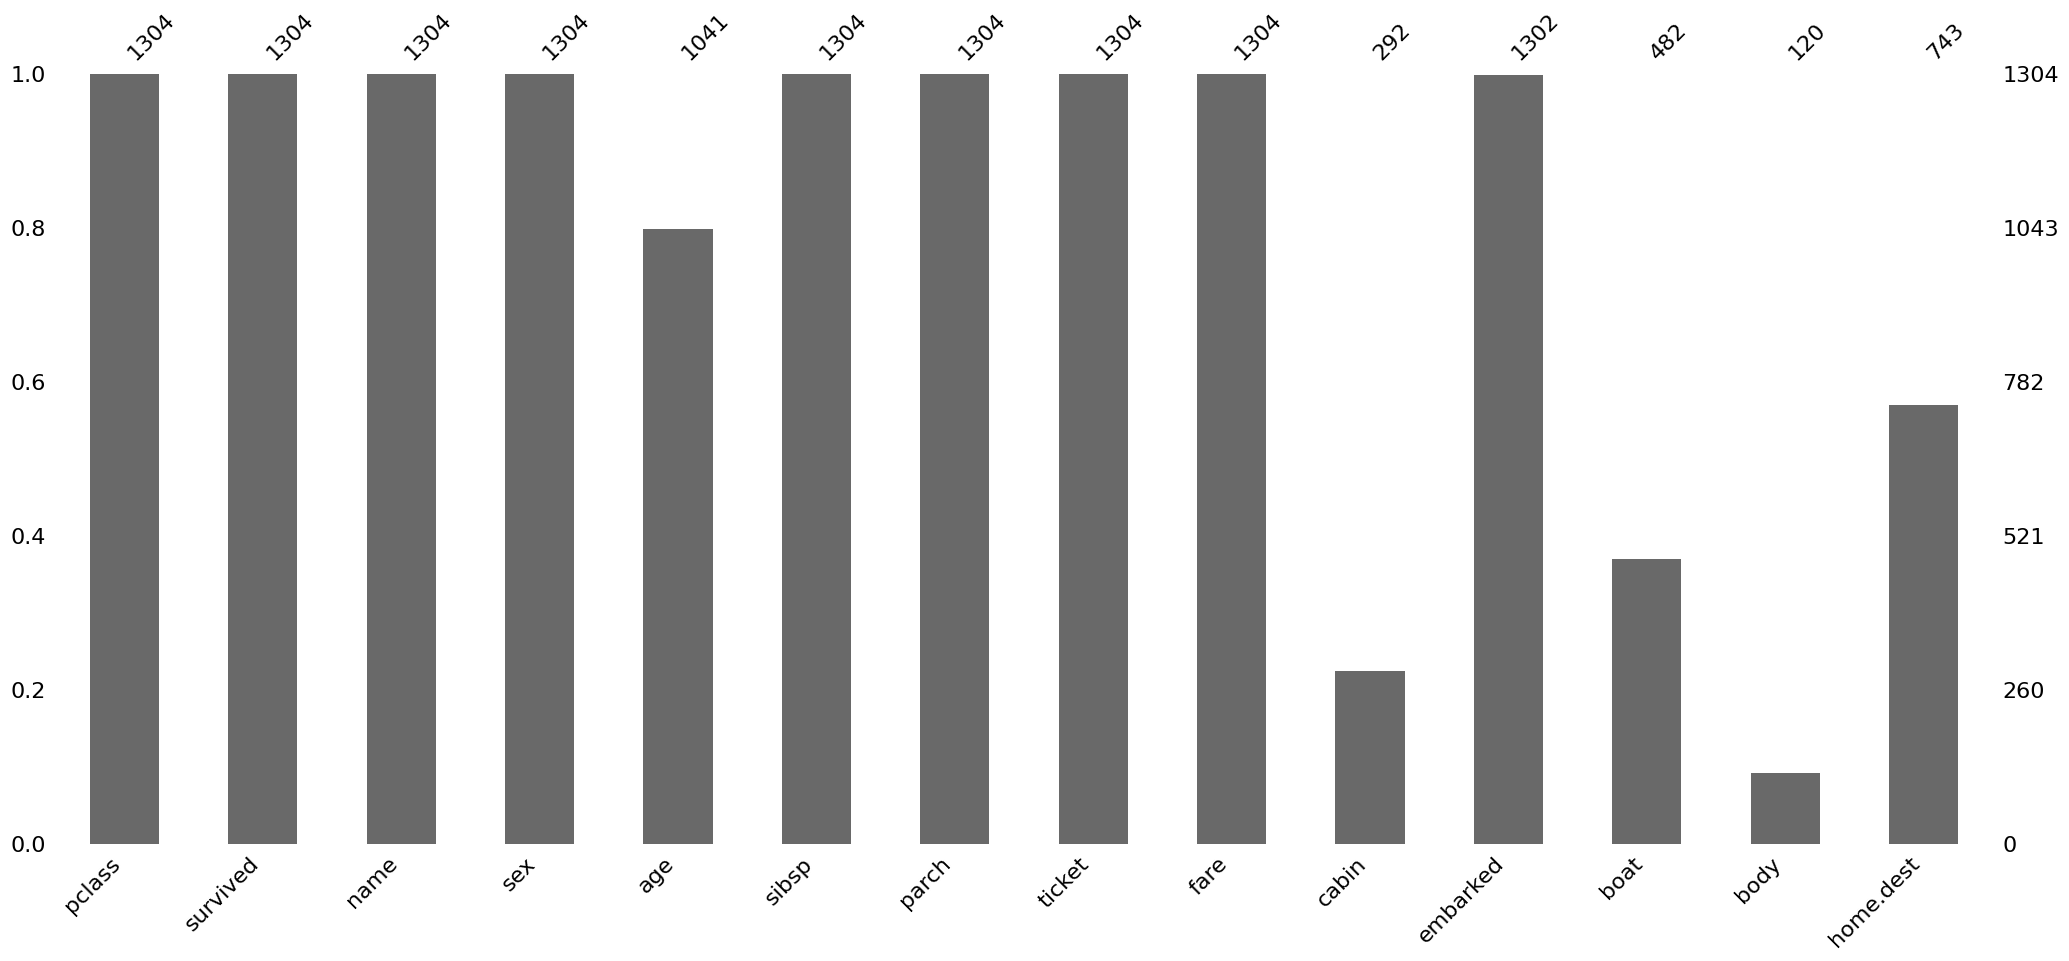

In [38]:
# We can even visualize this using the missingno library which helps to give a quick overview of your dataset completeness.
import missingno as msno 
msno.bar(df);

Age has some null values resulting in a slighty lower amount of data.
Cabin is low because only the rich could afford one so that makes sense.
Boat is low because only people who survived have a value there and even then not every survivor has a value.
Body is low because it immediatly eliminates anyone that survived but still only a small amount of bodies were found.
Only about half of all home destinations are known.

In [39]:
# Let's start with fixing the null values in age. First we check what the mean age is.
mean_age = df['age'].mean()
mean_age.round(0)

30.0

We have multiple options now on how we can fix the null values.
One could be to just simply remove the rows containing null values but 263 rows is a lot of good data to just simply delete.
Another option could be to replace the null values with the average age but what would happen then is that when we visualise our data there would be a spike with the amount of people that are exactly the mean age.
What we do instead is to replace the null values with the mean value but instead of assigning a fixed value we give random values but when you calculate the mean of those values they result in the mean of the current age.

In [40]:
# Calculate the mean age for non-null values
mean_age = df['age'].mean()

# Calculate the standard deviation of the age column and which will be used in the following line of code to get random but believable age values
std_age = df['age'].std()

# Generate the random numbers from a normal distribution using the numpy random function 
random_values = np.random.normal(loc=0, scale=std_age, size=df['age'].isna().sum())

# Shift the distribution to have the same mean as the original data
added_values = random_values + mean_age

# Replace missing values with the added values by using the df.loc[] method to locate the missing null values and replace them with the
# random values we created
df.loc[df['age'].isna(), 'age'] = added_values

# we check if it all null values have been replaced
df['age'].isna().sum()

0

In [41]:
# Next we will fix the cabin column, as seen in the missingno visualisation more than 70% is missing.
# This is just too much so we drop the table entirely because it will only be disadvantageous for our model if we keep it.
# df.drop(['cabin], axis = 1)

In [42]:
# There are 2 null values in the embarked column, because it is such a small amount of data we simply change it to the value 'Q'
# which stands for Queenstown
df['embarked'] = df['embarked'].replace(np.nan, 'Q')

In [43]:
# We check how many people that did survive still have a null value in the boat column. DIT WERKT NOG NIET!
count = len(df[(df['survived'] == '1') & df['boat'].isna()])
count
    

0

In [44]:
# We see that there are 0 survivors who still have a null value which means that all the null values are of people who did not survive
# Let's check this just to be sure, DIT WERKT NOG NIET!
count = len(df[(df['survived'] == '0') & df['boat'].isna()])
count

0

In [45]:
encoder = ce.OrdinalEncoder(cols=['sex'])
df_encoded = encoder.fit_transform(df)
df_encoded
# 1 = female, 2 = male

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",1,29.000000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",2,0.916700,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",1,2.000000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",2,30.000000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,25.000000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",1,14.500000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",1,-3.023105,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",2,26.500000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",2,27.000000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


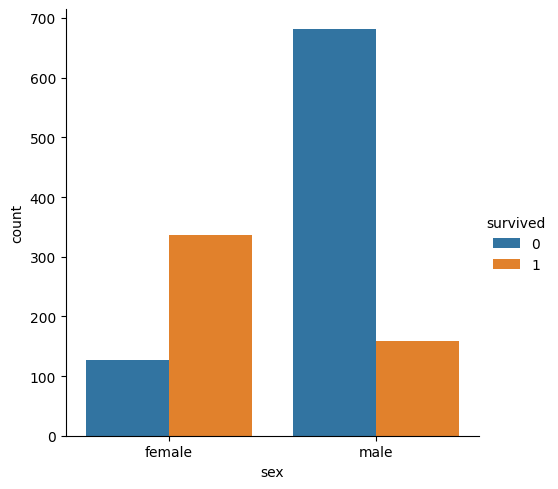

In [46]:
sns.catplot(x='sex', hue = 'survived', kind='count', data= df)
#sns.catplot(x='survived', hue = 'sex', kind='count', data= df)

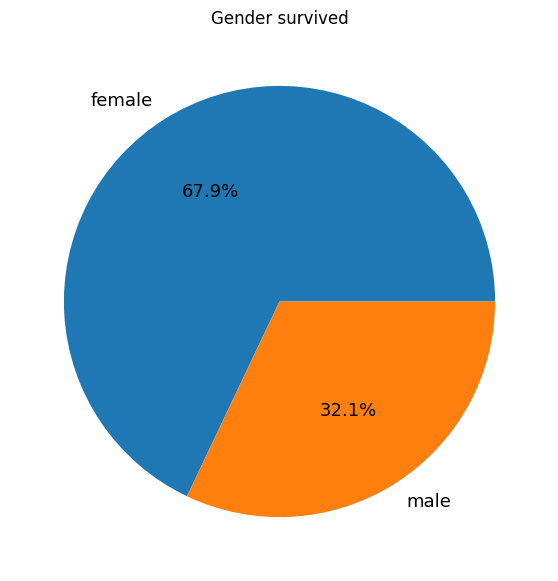

In [47]:
survived_sex= df.groupby('sex')['survived'].sum()
plt.figure(figsize=(7,7))
plt.title('Gender survived')
plt.pie(survived_sex,labels=['female','male'],autopct='%1.1f%%', textprops={'fontsize':13})
plt.show()

In [64]:
df['Firstname']=df['name'].str.split(r'[,.]', expand=True)[2].str.strip()
df['Title']=df['name'].str.split(r'[,.]', expand=True)[1].str.strip()
df['Lastname']=df['name'].str.split(r'[,.]', expand=True)[0].str.strip()

df.Title.value_counts()

Mr              754
Miss            259
Mrs             196
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Capt              1
Sir               1
Dona              1
Jonkheer          1
the Countess      1
Don               1
Mme               1
Lady              1
Name: Title, dtype: int64

In [65]:
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royal",
    "Don":        "Royal",
    "Sir" :       "Royal",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royal",
    "Dona":       "Royal",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royal"
}
# map the normalized titles to the current titles for train and test data.
df.Title = df.Title.map(normalized_titles)
df.Title.value_counts()

Mr         754
Miss       261
Mrs        199
Master      61
Officer     23
Royal        6
Name: Title, dtype: int64

In [66]:
df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,Firstname,Title,Lastname
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.000000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",Elisabeth Walton,Miss,Allen
1,1,1,"Allison, Master. Hudson Trevor",male,0.916700,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",Hudson Trevor,Master,Allison
2,1,0,"Allison, Miss. Helen Loraine",female,2.000000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Helen Loraine,Miss,Allison
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.000000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",Hudson Joshua Creighton,Mr,Allison
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.000000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Hudson J C (Bessie Waldo Daniels),Mrs,Allison
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.500000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN,Hileni,Miss,Zabour
1305,3,0,"Zabour, Miss. Thamine",female,-3.023105,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN,Thamine,Miss,Zabour
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.500000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN,Mapriededer,Mr,Zakarian
1307,3,0,"Zakarian, Mr. Ortin",male,27.000000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN,Ortin,Mr,Zakarian
